# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [6.0, 6.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
})

# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam #ottimizzatori
from keras.layers import Flatten, Conv2D, MaxPooling2D, AveragePooling2D #filtri


### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [73]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [74]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

In [75]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

#### Soluzione 12.1
Sviluppiamo delle Deep Neural Network (DNN), implementate con il pacchetto Keras di phyton, per riconoscere 10 cifre (da 0 a 9) scritte in bianco su sfondo nero in una griglia di $28x28$ pixel.\
Alleniamo la rete con il dataset MINST che contiene 70.000 cifre.

Creaiamo la rete con 2 layer con funzione di attivazione `relu`. 
Usiamo come loss function la `categorical_crossentropy`.
Facciamo diversi modelli modificando il tipo di ottimizzatore per ottimizzare i pesi della rete e il nuermo di epoche.

Ottimizzatori:  `SGD`, `Adam`, `Nadam`

Epoche: $5, 8, 10$


In [76]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

def compile_model(optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model architecture created successfully!
Model compiled successfully and ready to be trained.


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.6478 - loss: 1.1455 - val_acc: 0.9119 - val_loss: 0.3138
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8845 - loss: 0.4067 - val_acc: 0.9317 - val_loss: 0.2413
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.9099 - loss: 0.3257 - val_acc: 0.9410 - val_loss: 0.2034
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.9224 - loss: 0.2739 - val_acc: 0.9480 - val_loss: 0.1778
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.9328 - loss: 0.2394 - val_acc: 0.9509 - val_loss: 0.1610
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9409 - loss: 0.1880

Test loss: 0.16099829971790314
Test accuracy: 0.9509000182151794
Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.6313 - loss: 1.1881 - val_acc: 0.9099 - val_loss: 0.3242
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.8801 - loss: 0.4252 - val_acc: 0.9300 - val_loss: 0.2445
Epoch 3/8
1875/1875 ━━━━

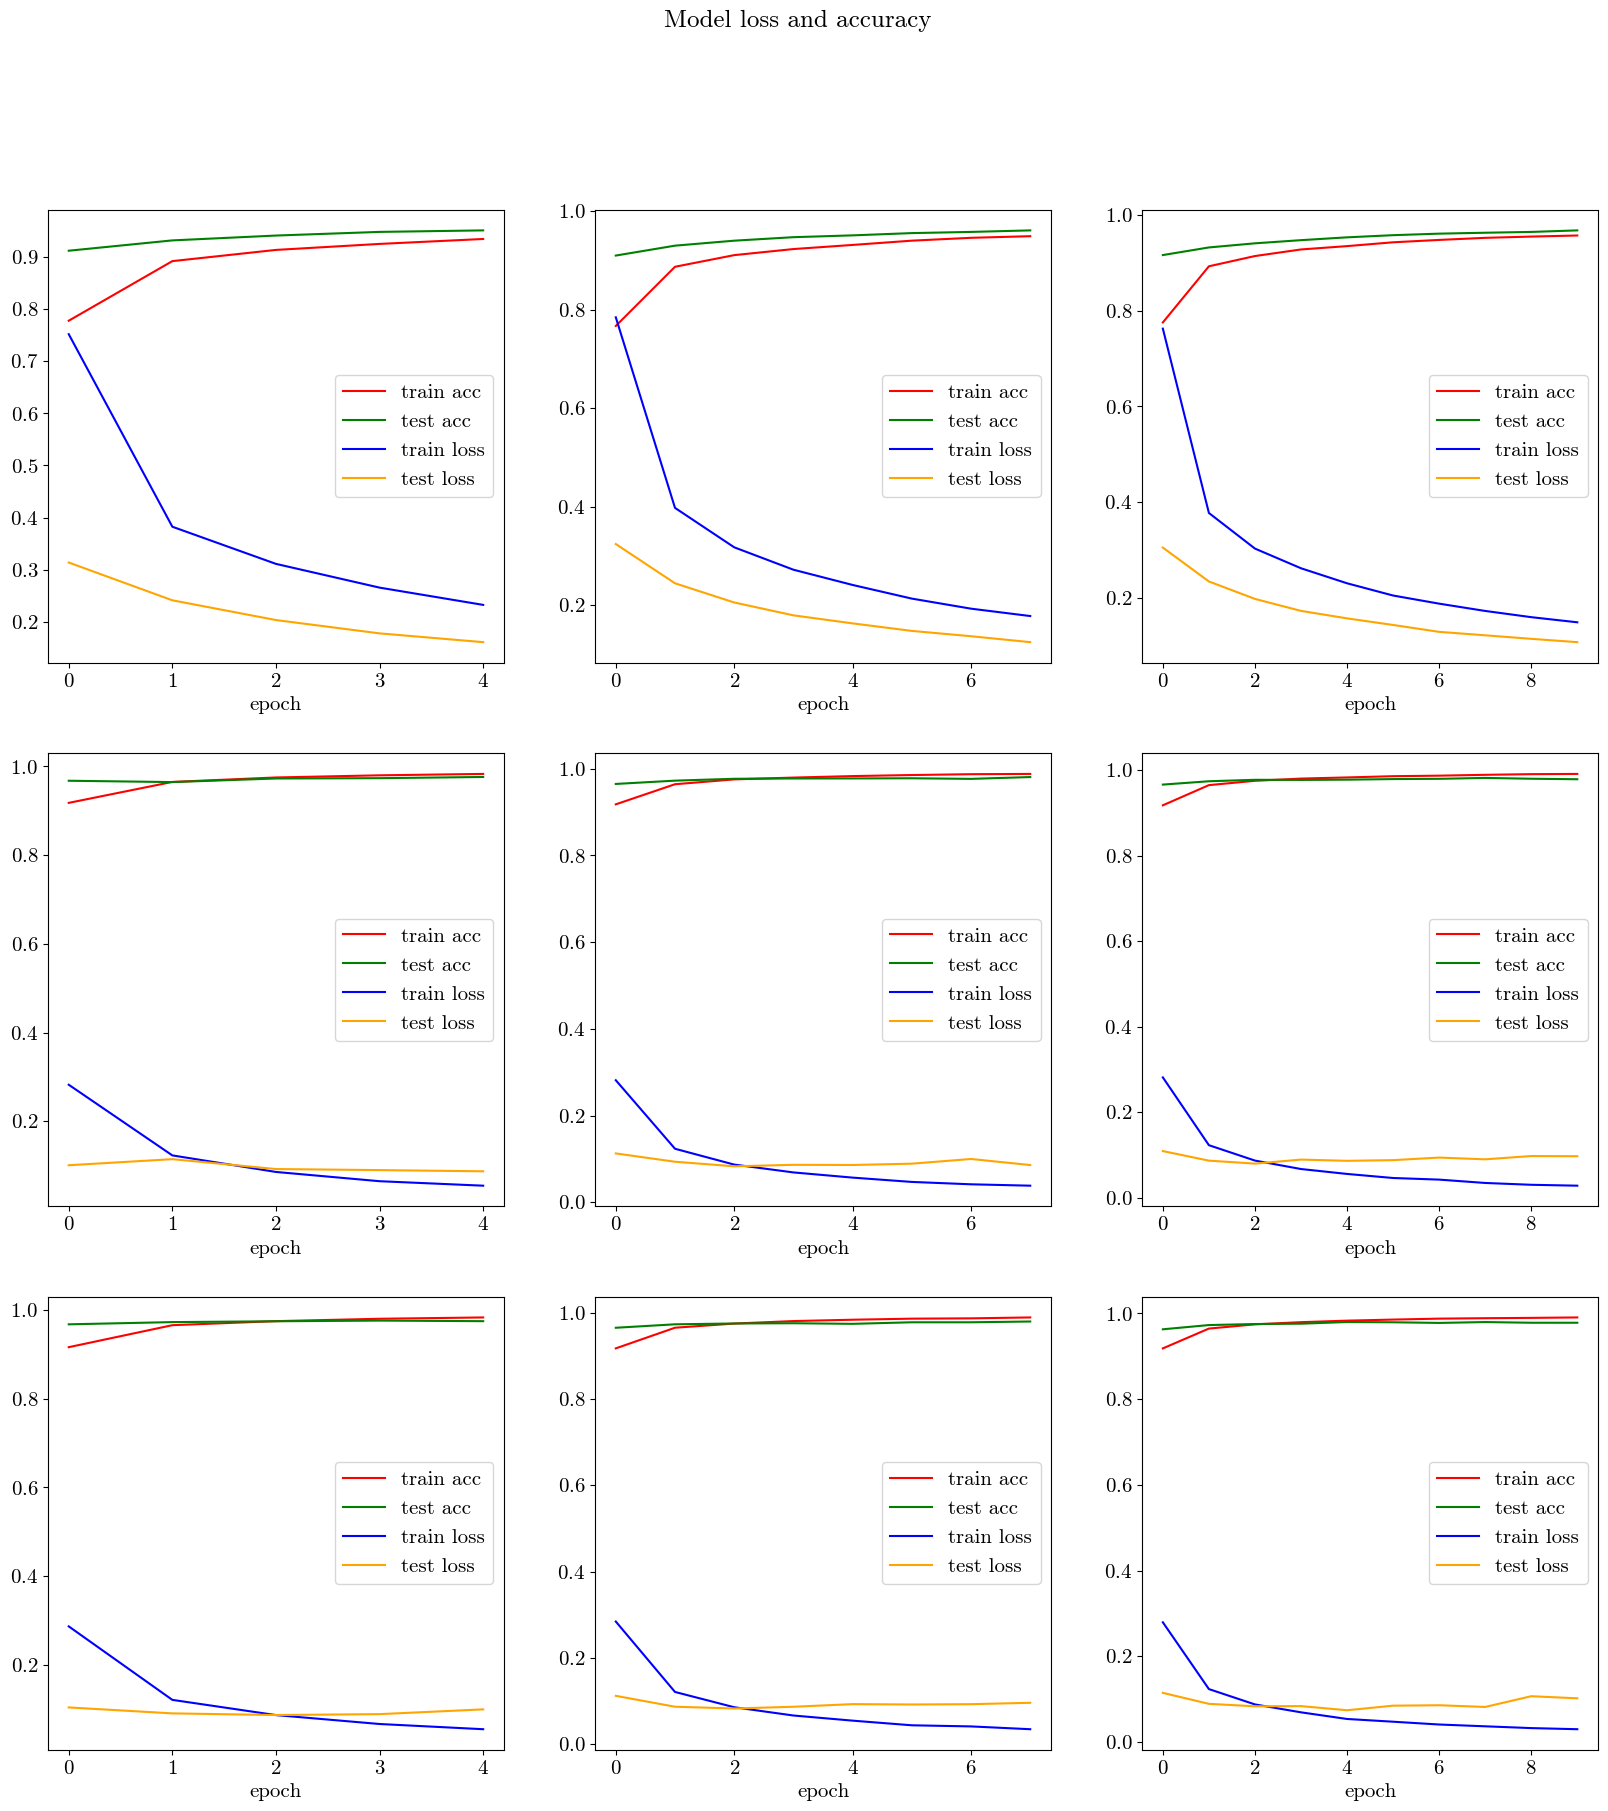

In [77]:
# training parameters
batch_size = 32
optimizer =[SGD, Adam, Nadam]
epochs = [5, 8, 10]
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Model loss and accuracy')
for i in range(3):
    for j in range(3):
        # create the deep neural net
        model_DNN = compile_model(optimizer[i])

        # train DNN and store training info in history
        history = model_DNN.fit(X_train, Y_train,
                  batch_size=batch_size,
                  epochs=epochs[j],
                  shuffle=True, # a good idea is to shuffle input before at each epoch
                  verbose=1,
                  validation_data=(X_test, Y_test))
        # evaluate model
        score = model_DNN.evaluate(X_test, Y_test, verbose=1)
    
        # print performance
        print()
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
    
        ax = axes[i,j]
        # look into training history
        
        # summarize history for accuracy
        ax.plot(history.history['acc'], color = 'red')
        ax.plot(history.history['val_acc'], color = 'green')
        #ax.set_ylabel('model accuracy')
        ax.set_xlabel('epoch')
        #ax.legend(['train acc', 'test acc'], loc='best')
        #ax.show()
        #summarize history for loss
        ax.plot(history.history['loss'], color = 'blue')
        ax.plot(history.history['val_loss'], color = 'orange')
        #ax.set_ylabel('model loss')
        #ax.set_xlabel('epoch')
        ax.legend(['train acc', 'test acc', 'train loss', 'test loss'], loc='best')

Ogni riga della griglia dei grafici rappresenta i risultati ottenuti con un certo ottimizzatore.
Vediamo che l'ottimizzatore peggiore è `SGD`, mentre gli altri due raggiungono risulatati molto simili. Come per le reti neurali che abbiamo usato nell'esercizio precedente più eoche abbiamo più l'accuraratezza della predizione è migliore e la loss scende, però vediamo che non c'è molta differenza tra 8 e 10 epoche quindi dopo useremo 8 epoche per ridurre il tempo computazionale.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [78]:
# you will need the following for Convolutional Neural Networks
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train_CNN = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test_CNN = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_CNN = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test_CNN = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train_CNN.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train_CNN.shape[0], 'train samples')
print(X_test_CNN.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

#### Soluzione 12.2
In una Convolutional Neural Network (CNN) si applicano dei filtri che sono in grado di riconoscere delle features specifiche dell'immagine (es. bordi, curve...).
Si alternano dei neuroni con i filtri a dei neuroni con i pooling. Il pooling serve a rimpicciolire la matrice che alla fine deve essere ridotta a un array (con un Flatten). I passaggi intermedi con la CNN servono per rendere più efficiente la rete e non perdere delle caratteristiche.
Alla fine infatti bisogna usare la rete normale per riconoscere il numero a partire dall'array che si è ottenuto dopo aver fatto il Flatten della matrice.

Quindi costruiamo una rete che alterna `Conv2D` a operazioni di Pooling (`MaxPooling` e `AveragePooling`). Alla fine mettiamo un `Flatten` per rende array la matrice a cui si è arrivati e due layer di una rete DNN uno con funzione di attivazione `relu` e l'altro con `softmax`.

In [79]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3), strides=None, padding="valid"))
    model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2,2), strides=None, padding="valid"))
    model.add(Flatten())
    model.add(Dense(20,activation='relu'))
    model.add(Dense(10,activation='softmax')) # metto 10 perchè le cifre da riconoscere sono 10
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [80]:
# training parameters
batch_size = 32
epochs = 8

# create the deep conv net
model_CNN=create_CNN()

# train CNN
histo = model_CNN.fit(X_train_CNN, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_CNN, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test_CNN, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/home/catezac/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.3855 - loss: 1.7562 - val_acc: 0.8652 - val_loss: 0.4407
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.8751 - loss: 0.4011 - val_acc: 0.9232 - val_loss: 0.2606
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.9257 - loss: 0.2404 - val_acc: 0.9463 - val_loss: 0.1723
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9469 - loss: 0.1746 - val_acc: 0.9592 - val_loss: 0.1283
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9565 - loss: 0.1409 - val_acc: 0.9669 - val_loss: 0.1050
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.9627 - loss: 0.1211 - val_acc: 0.9706 - val_loss: 0.0900
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9668 - loss: 0.1079 - val_acc: 0.9747 - val_loss: 0.0802
Epoch 8/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - acc: 0.9696 - loss: 0.0986 - val_acc: 0.9777 - val_loss: 0.0730
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Vautiamo la performance della rete CNN come abbiamo fatto per la DNN, graficando loss e accuracy.

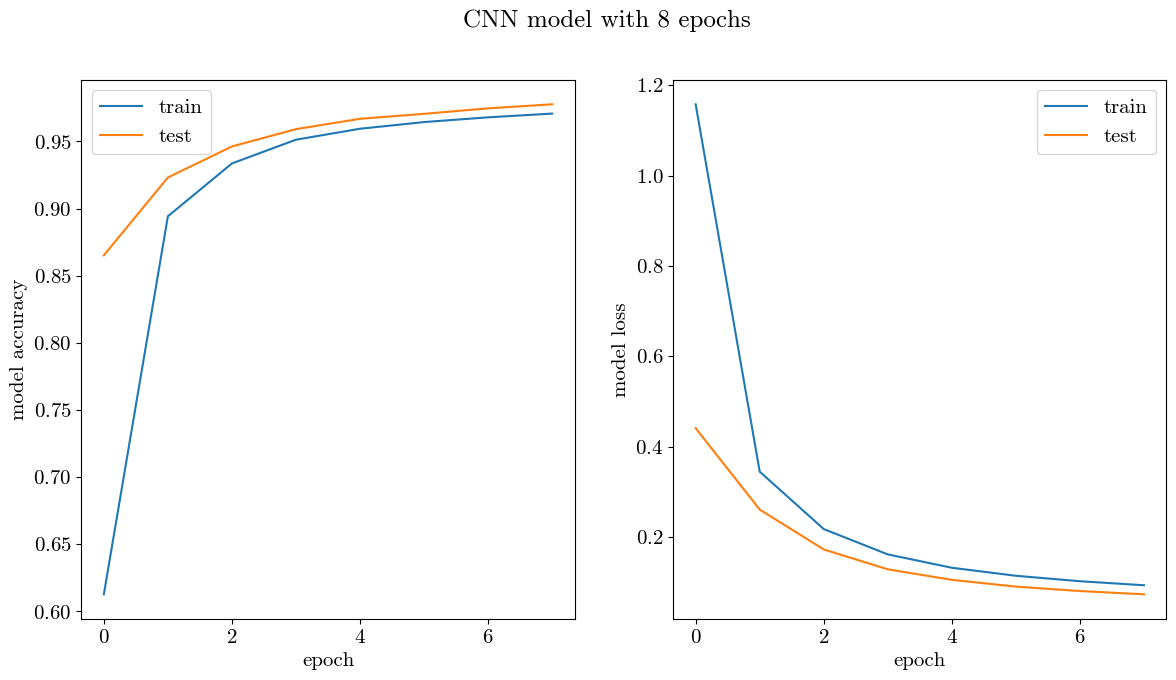

In [81]:
fig = plt.figure(1, figsize = (14,7))
fig.suptitle('CNN model with 8 epochs')
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(histo.history['acc'])
plt.plot(histo.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.figure(1)
plt.subplot(1,2,2)
# summarize history for loss
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

#### Soluzione 12.3 
Creiamo con `gimp` un dataset che contiene le 10 cifre scritte a mano per verificare che il modello CNN che abbiamo creato e allenato funzioni.

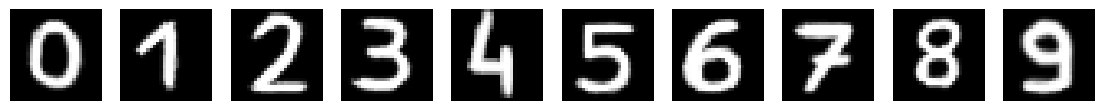

In [82]:
from PIL import Image
import os

digit_filename = []
digit_in = []
pix = []
data = []
plt.figure(figsize=(14,7))
for k in range(10):
    digit_filename.append("./numeri/"+str(k)+".png")
    digit_in.append(Image.open(digit_filename[k]).convert('L'))
    ydim, xdim = digit_in[k].size
    #print("Image size: "+str(xdim)+"x"+str(ydim))
    pix.append(digit_in[k].load())
    data.append(np.zeros((xdim, ydim)))
    for j in range(ydim):
        for i in range(xdim):
            data[k][i,j]=pix[k][j,i]
    data[k] /= 255
    plt.subplot(2,10,k+1)
    plt.imshow(data[k], cmap='gray')
    plt.axis('off')


Usiamo le reti allenate prima (DNN e CNN) per predire i numeri disegnati e confrontiamo i risultati di predizione ottenuti dalle due reti. Come DNN uso quella con accuracy più alta e che raggiunge una loss più bassa. Quindi quella con `Nadam` come ottimizzatore e con $8$ epoche. Come CNN uso quella creata prima con lo stesso numero di epoche della DNN.

In [83]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

model_DNN_best = compile_model(Nadam)

# train DNN and store training info in history
history_best = model_DNN_best.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=8,
            shuffle=True, # a good idea is to shuffle input before at each epoch
            verbose=1,
            validation_data=(X_test, Y_test))
# evaluate model
score_best = model_DNN_best.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score_best[0])
print('Test accuracy:', score_best[1])

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.8559 - loss: 0.4795 - val_acc: 0.9667 - val_loss: 0.1085
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9601 - loss: 0.1369 - val_acc: 0.9709 - val_loss: 0.0932
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - acc: 0.9706 - loss: 0.0984 - val_acc: 0.9760 - val_loss: 0.0796
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - acc: 0.9786 - loss: 0.0734 - val_acc: 0.9767 - val_loss: 0.0806
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - acc: 0.9813 - loss: 0.0615 - val_acc: 0.9801 - val_loss: 0.0827
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - acc: 0.9839 - loss: 0.0514 - val_acc: 0.9799 - val_loss: 0.0895
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - acc: 0.9867 - loss: 0.0424 - val_acc: 0.9808 - val_loss: 0.0832
Epoch 8/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - acc: 0.9881 - loss: 0.0372 - val_acc: 0.9811 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


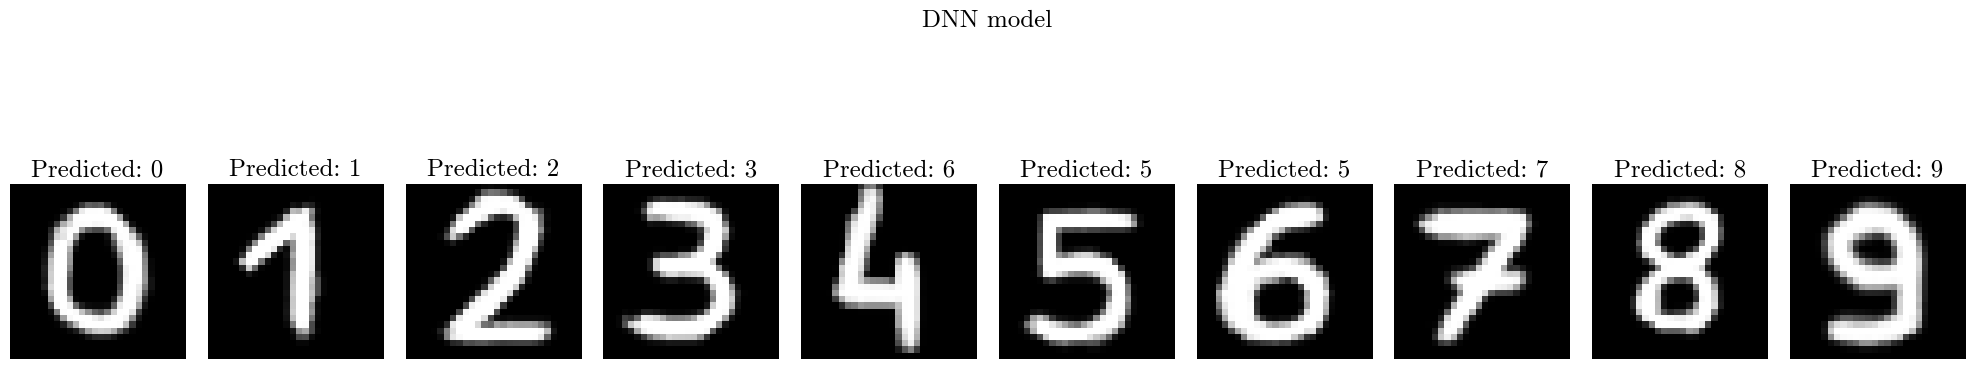

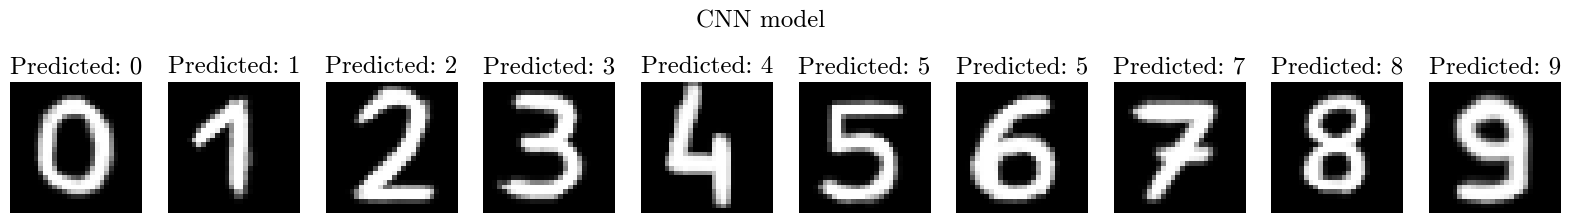

In [84]:
fig = plt.figure(1, figsize=(20, 5)) 
fig.suptitle('DNN model')
pred_0 = []
for k in range(10):
    ydim, xdim = digit_in[k].size
    data[k] = data[k].reshape(1,xdim*ydim)
    pred_0.append(model_DNN_best.predict(data[k]))

    data[k] = data[k].reshape(xdim,ydim)
    plt.subplot(1,10,k+1) 
    plt.imshow(data[k], cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(pred_0[k])))
    plt.axis('off')
plt.tight_layout()
plt.show()

fig = plt.figure(2, figsize=(20, 5)) 
fig.suptitle('CNN model')
for k in range(0,10):
    data[k] = data[k].reshape(1,xdim,ydim,1)
    pred_0 = model_CNN.predict(data[k],verbose=0)

    data[k] = data[k].reshape(xdim,ydim)
    plt.subplot(2,10,k+1)
    plt.imshow(data[k], cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(pred_0)))
    plt.axis('off') 
plt.show()

Vediamo che il modello CNN funziona meglio, infatti riconosce dei numeri che il modello DNN non riconosceva $(es. 4)$.